# TL;DR

This notebook is used to run experiments for offline data analysis section in the Aquarius paper. 

# Import libs & utils fn

In [2]:
import sys
import os
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu
import time
from scipy import stats
import numpy as np
import json
import pandas as pd

In [3]:
# configure the MACROs here
EXPERIMENT = 'offline'
DATA_DIR = '../../data/reproduce/{}'.format(EXPERIMENT)
USER = 'yzy'
GLOBAL_CONF = tu.json_read_file('../../config/global_conf.json')
ROOT_DIR = GLOBAL_CONF['dir']['root']
# local machine hostname
LOCAL_MACHINE = !hostname
LOCAL_MACHINE = LOCAL_MACHINE[0]
SERVER_IPS = GLOBAL_CONF['net']['physical_server_ip']
# local machine ID
LOCAL_ID = SERVER_IPS.index(LOCAL_MACHINE)
REMOTE_IDS = [i for i, v in enumerate(SERVER_IPS) if v != LOCAL_MACHINE]
SHM_LAYOUT = tu.json_read_file("../../src/lb/dev/shm_layout_base.json")
FEATURE_AS_CNT = [_[1] for _ in SHM_LAYOUT["vpp"]["struct"]["as_stat"][1:]] # counter features gathered for each AS in as_stat_t
FEATURE_AS_RES = [_[1] for _ in SHM_LAYOUT["vpp"]["struct"]["reservoir_as"]] # features gathered for each AS w/ reservoir sampling
RES_FEATURE_ENG = ["avg", "90", "std", "avg_decay", "90_decay"]
FEATURE_AS_ALL = FEATURE_AS_CNT + ["_".join((a, b)) for a in FEATURE_AS_RES for b in RES_FEATURE_ENG]
GT = ["cpu", "memory", "apache", "asid"]

## For running experiments

In [4]:
def run_pipeline(
    lb_method = 'aquarius_ecmp',
    trace='wiki',
    experiment='offline',
    sample='hour0.csv',
    from_orig=False,
    config_file_prefix='1lb-36core',
    clip_n=20000,
    n_episode=1,
    episode_base=0,
    remote_servers=[0, 2, 3],
    clt_server=0,
):
    '''
    @brief: run a set of experiments with a specific setup
    @params:
        lb_method: method name defined in config/lb_methods.json
        trace: trace type as in data/trace/*
    '''
    global USER, ROOT_DIR, LOCAL_ID, REMOTE_IDS, SERVER_IPS
    assert set(remote_servers) - set(REMOTE_IDS) == set()
    config_file = config_file_prefix+'-'+str(LOCAL_ID)
    config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in REMOTE_ID}

    for episode in range(episode_base, episode_base+n_episode):
    
        task_name, task_dir, nodes = tu.init_task_info(
            experiment=experiment,
            lb_method=lb_method,
            trace=trace,
            sample=sample,
            filename=config_file+'.json',
            colocate=colocate,
            colocate_freq=colocate_freq,
            alias=config_file_prefix,
        )

        print(">> run task {} - episode {}".format(task_name, episode))

        #--- spin up ---#
        for server_id in remote_servers:
            cmd = 'ssh -t {}@{} "python3 {}/src/utils/run_server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
                USER, SERVER_IPS[server_id], ROOT_DIR, experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id])

            if colocate:
                cmd += ' --colocate {}'.format(colocate)
            if clip_n and server_id == 0:
                cmd += ' -n {}'.format(clip_n)
            tu.subprocess.Popen(cmd, shell=True)
        

        tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

        tu.runall()
        time.sleep(10)
        
        #--- check network ---#

        net_ok = False
        while not net_ok:
            try:
                tu.gt_socket_check()
                net_ok = True
            except:
                print('error')
                time.sleep(1)

        time.sleep(3)

        # start gathering at LB node
        for lb in tu.NODES['lb']:
            lb.run_init_bg()

        # run traffic
        t0 = time.time()
        cmd = 'ssh -t {}@{} "python3 {}/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
            USER, SERVER_IPS[clt_server], ROOT_DIR, experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
        tu.subprocess_cmd(cmd)
        print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))
        time.sleep(5)

        # fetch results from nodes
        for server_id in REMOTE_IDS:
            cmd = 'ssh -t {}@{} "python3 {}/src/utils/shutdown_server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
                USER, SERVER_IPS[server_id], ROOT_DIR, experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], episode)
            tu.subprocess.Popen(cmd, shell=True)

        for lb in tu.NODES['lb']:
            lb.fetch_result(task_dir, episode)

        tu.shutall()

## Data Processing

In [16]:
def clip_outliers(X):
    X = np.array(X)
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    # X is the 1D data array
    z_scores = stats.zscore(X)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return X[filtered_entries]

def load_shm(filename, as_range, as_split_by, normalize=False, minmax=True):
    global FEATURE_AS_ALL, GT
    min_max_scale = lambda x: (x - x.min()) / (x.max() - x.min())
    normalize = lambda x: (x - x.mean())/x.std()
    lines = tu.read_file(filename)
    lines = lines[int(0.2*len(lines)):int(0.8*len(lines))]
    df_dict = {
        'asid': [],
        '#cpu': [],
    }
    df_dict.update({k: [] for k in FEATURE_AS_ALL})
    df_dict.update({k: [] for k in GT})
    for l in lines:
        d = json.loads(l)
        for as_id in as_range:
            for i, k in enumerate(FEATURE_AS_ALL):
                df_dict[k].append(d['feature_as'][as_id][i])
            for i, k in enumerate(GT):
                df_dict[k].append(d['gt'][as_id][i])
            if df_dict['asid'][-1] < as_split_by: ncpu = 1
            else: ncpu = 2
            df_dict['#cpu'].append(ncpu)
    for k, v in df_dict.items():
        if k in ['asid', '#cpu']: continue
    if normalize: df_dict[k] = normalize(np.array(v))
    if minmax: df_dict[k] = min_max_scale(np.array(v))
    df_dict['cpu usage'] = df_dict['cpu']
    df_dict['#thread'] = df_dict['apache']
    del(df_dict['cpu'])
    del(df_dict['apache'])
    return pd.DataFrame.from_dict(df_dict)

def get_page_load_time(filename, ep=None, verbose=False):
    traces = !ls {filename}
    traces = [t for t in traces if 'trace' in t]
    if ep:
        if ep == -1:
            traces = [t for t in traces if 'ep' not in t]
        else:
            traces = [t for t in traces if 'ep{}'.format(ep) in t]

    
    page_load_time = []
    page_load_time_wiki = []
    page_load_time_static = []
    n_timeout = 0
    n_reset = 0
    n_sent = 0
    n_encode = 0
    n_404 = 0
    n_closed = 0
    
    for t in traces:
        if verbose: print("parsing trace {}".format(t))
        plt_all, plt_wiki, plt_static = [], [], []
        wiki_log = tu.read_file(os.path.join(filename, t))
        for line in wiki_log:
            _ = line.split(' ')[-1]
            if ' failed ' not in line:
                plt_all.append(float(_))
                if 'wiki/index.php' in line:
                    plt_wiki.append(float(_))
                else:
                    plt_static.append(float(_))
                
            elif '[Errno 110]' in line:
                n_timeout += 1
            elif '[Errno 104]' in line:
                n_reset += 1
            elif 'Request-sent' in line:
                n_sent +=1
            elif 'HTTP_404' in line:
                n_404 += 1
            elif "\'ascii\' codec can\'t encode" in line:
                n_encode += 1
            elif "closed connection without response" in line:
                n_closed += 1
            else:
                print(line)
        
        # log if verbose
        if verbose:
            for k, plt_ in zip(['all', 'wiki', 'static'], [plt_all, plt_wiki, plt_static]):
                plt_ = np.array(plt_)
                print("plt {}: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(k, plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
        page_load_time += plt_all
        page_load_time_wiki += plt_wiki
        page_load_time_static += plt_static

    return {
        'page_load_time': page_load_time, 
        'plt_wiki': page_load_time_wiki, 
        'plt_static': page_load_time_static, 
        'timeout': n_timeout, 
        'n_reset': n_reset,
        'n_sent': n_sent,
        'n_404': n_404
    }
    

## Plot

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

COLORS = ["#3978af", 
          "#d1342b",
          "#559d3f",
          "#ef8532", 
          "#634295", 
          "#a65d34", 
          "#aecde1", 
          "#b4dc93",
          "#ee9e9b", 
          "#f4c07b", 
          "#c6b4d3",
          "#fffea6",
          "#df3583"
]

# Table of Contents

1. Server states inference from network features (section 4.1.1)
2. Traffic classification (section 4.1.2)
3. Overhead analysis (section 4.1.3)

##  Server States Inference from Network Features

### Wiki Trace

In [34]:
method = 'aquarius_ecmp'
samples = ['hour{}.csv'.format(i) for i in [8, 12]]
config_prefix = ['conf0{}'.format(i) for i in [1]]
trace = 'wiki'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
print("=== running method {} ===".format(method))
for sample in samples:
    print(">> sample {}".format(sample))
    for config in config_prefix:
        run_pipeline(
            lb_method=method,
            trace=trace,
            experiment=EXPERIMENT,
            sample=sample,
            from_orig=from_orig,
            config_file_prefix=config,
            clip_n=clip_n,
            n_episode=n_episode,
            episode_base=episode_base
            remote_servers=remote_servers,
            clt_server=clt_server,
        )        

### Load Dataset

In [116]:
trace_types = [
    'Wiki'
]
trace_ids = [
    'wiki'
]
server_ranges = [
    range(8, 16)
]
server_split_bys = [
    4
]
rates = [
    [221883/600, 311276/600]
]
task_ids = [
    ['hour{}-conf01'.format(h) for h in [12, 8]]
]
method = 'aquarius_ecmp'
ep = 0
dfs = [] # to store all dataframes
for trace_type, trace_id, server_range, server_split_by, rate_list, task_id_list in zip(trace_types, trace_ids, server_ranges, server_split_bys, rates, task_ids):
    for rate, task_id in zip(rate_list, task_id_list):
        print("== process | {} | {} | rate={} ".format(trace_type, task_id, rate))
        filename = "{}/{}/{}/{}/0_log_ep{}/shm.json".format(DATA_DIR, trace_id, method, task_id, ep)
        df = load_shm(filename, server_range, server_split_by, minmax=False)
        dfs.append(df)
        dfs[-1]['Traffic Rate'] = rate
        dfs[-1]['Trace'] = trace_type
df_all = pd.concat(dfs).fillna(0)

== process | Wiki | hour12-conf01 | rate=369.805 
== process | Wiki | hour8-conf01 | rate=518.7933333333333 


In [117]:
cols_all = list(df.columns)
col2plot = [col for col in cols_all if col not in ['cpu usage', 'memory', '#thread', 'asid', '#cpu', 'Traffic Rate', 'Trace', 'n_ooo', 'n_dpk']]
row2plot = ['#cpu', 'cpu usage', '#thread']
# clip outliers
df_all = df_all[(np.nan_to_num(np.abs(stats.zscore(df_all[col2plot]))) < 3).all(axis=1)]

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [118]:
# min max scale
min_max_scale = lambda x: (x - x.min()) / (x.max() - x.min())

for col in col2plot:
    df_all[col] = min_max_scale(np.array(df_all[col]))

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


### Plot Correlation

In [90]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

def plot_heatmap(trace, filename=None):
    print("plot for trace {}".format(trace))
    df_ = df_all.loc[df_all['Trace'] == trace]
    trace_rate = df_['Traffic Rate'].unique()

    fig, axs = plt.subplots(len(trace_rate), figsize=(20, 2*len(trace_rate)), dpi=96)
    plt.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.2,   # the amount of width reserved for blank space between subplots
    hspace = 0.3,   # the amount of height reserved for white space between subplots
    )

    for i, rate in enumerate(trace_rate):
        plt.sca(axs[i])
        ax = sns.heatmap(df_.loc[df_['Traffic Rate'] == rate].corr().iloc[[i for i, v in enumerate(cols_all) if v in row2plot], [i for i, v in enumerate(cols_all) if v in col2plot]], vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f", annot_kws={'rotation': 90}, cbar=False)
        plt.yticks(rotation=30) 
        if i < len(trace_rate) - 1: axs[i].xaxis.set_visible(False)
        plt.title("Traffic Rate = {:d} queries/s".format(int(rate)), y=0.9)
        if i == 0:
            # plot colorbar
            ax_divider = make_axes_locatable(ax)
            # define size and padding of axes for colorbar
            cax = ax_divider.append_axes('top', size = '5%', pad = '25%')
            # make colorbar for heatmap. 
            cb = plt.colorbar(ax.get_children()[0], cax=cax, orientation = 'horizontal')
            cb.outline.set_visible(False)
            # locate colorbar ticks
            cax.xaxis.set_ticks_position('top')
    plt.show()
    if filename:
        fig.savefig(filename, bbox_inches='tight', transparent=True)

plot for trace Wiki


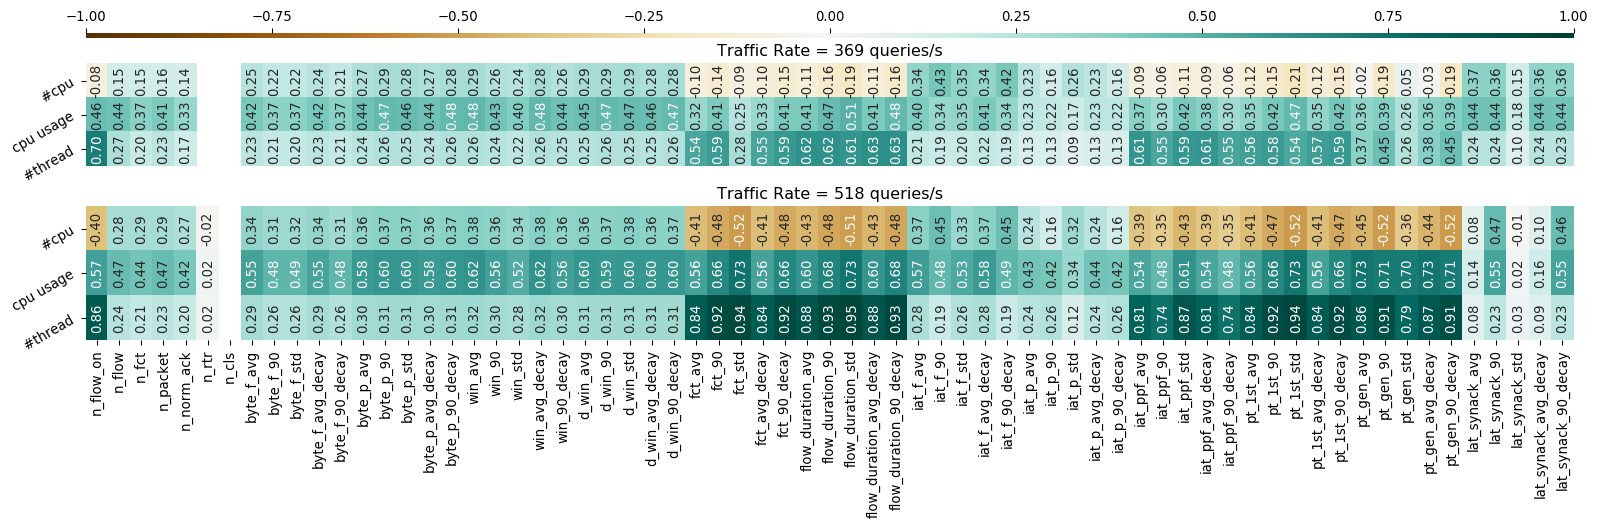

In [119]:
for trace in trace_types:
    plot_heatmap(trace)

### Plot PCA

In [123]:
from scipy import stats
from sklearn import datasets
from sklearn.decomposition import PCA

df_all = df_all.loc[df_all['memory']>0]
pca = PCA()
# study only correlated features
col2pca = [col for col in col2plot if ('fct_' in col or 'flow_duration_' in col or 'pt_' in col or col == 'n_flow_on') and ('decay' not in col)]
X = pca.fit_transform(df_all.loc[df_all['Trace']=='Wiki'][col2pca].values)

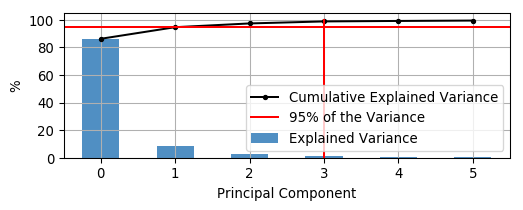

In [124]:
f = plt.figure(figsize=(6,2), dpi=96)
n_var = 6
plt.bar(range(n_var), pca.explained_variance_ratio_[:n_var], color='#508fc3', width=0.5, label="Explained Variance")
plt.plot(range(n_var), [sum(pca.explained_variance_ratio_[:i]) for i in range(1, n_var+1)], 'k-o', markersize=3, label="Cumulative Explained Variance")
plt.plot(range(-2, n_var+2), [0.95]*(n_var+4), 'r', label='95% of the Variance')
plt.plot([3]*(2), range(0, 2), 'r')
plt.ylabel('%')
plt.xlabel('Principal Component')
plt.legend()
plt.grid(True)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 20, 40, 60, 80, 100])
plt.xlim(-0.5, n_var-.5)
plt.show()

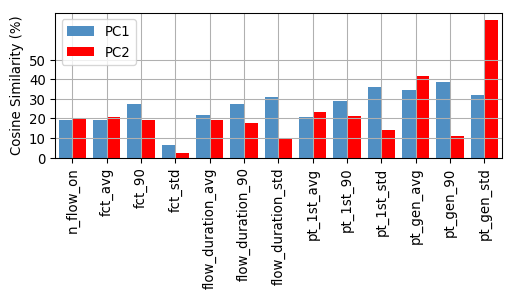

In [125]:
f = plt.figure(figsize=(6,2), dpi=96)
width=0.4
n_var = len(col2pca)
r = np.array(range(n_var))
plt.bar(r-width/2, abs(pca.components_[0]), color='#508fc3', width=width, label="PC1")
plt.bar(r+width/2, abs(pca.components_[1]), color='r', width=width, label="PC2")
plt.ylabel('Cosine Similarity (%)')
plt.legend()
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], [0, 10, 20, 30, 40, 50])
plt.xticks(r, col2pca, rotation=90)
plt.xlim(-0.5, n_var-.5)
plt.grid(True)
plt.show()

## Traffic Classification

### Poisson For-Loop Trace

In [34]:
method = 'aquarius_ecmp'
samples = ['rate_{}.csv'.format(i) for i in [350, 500]]
config_prefix = ['2lb-168cpu']
trace = 'poisson_for_loop'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
print("=== running method {} ===".format(method))
for sample in samples:
    print(">> sample {}".format(sample))
    for config in config_prefix:
        run_pipeline(
            lb_method=method,
            trace=trace,
            experiment=EXPERIMENT,
            sample=sample,
            from_orig=from_orig,
            config_file_prefix=config,
            clip_n=clip_n,
            n_episode=n_episode,
            episode_base=episode_base
            remote_servers=remote_servers,
            clt_server=clt_server,
        )        

### Poisson File Trace

In [34]:
method = 'aquarius_ecmp'
samples = ['rate_{}.csv'.format(i) for i in [400, 600, 800, 1000]]
config_prefix = ['2lb-168cpu']
trace = 'poisson_for_loop'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
print("=== running method {} ===".format(method))
for sample in samples:
    print(">> sample {}".format(sample))
    for config in config_prefix:
        run_pipeline(
            lb_method=method,
            trace=trace,
            experiment=EXPERIMENT,
            sample=sample,
            from_orig=from_orig,
            config_file_prefix=config,
            clip_n=clip_n,
            n_episode=n_episode,
            episode_base=episode_base
            remote_servers=remote_servers,
            clt_server=clt_server,
        )        

### Load Dataset

In [ ]:
trace_types = [
    'PHP For-Loop', 
    'PHP File', 
    'Wiki'
]
trace_ids = [
    'poisson_for_loop', 
    'poisson_file', 
    'wiki'
]
server_ranges = [
    range(1, 61), 
    range(1, 61), 
    range(8, 16)
]
server_split_bys = [
    36, 
    36, 
    4
]
rates = [
    [350, 500], 
    [400, 600, 800, 1000], 
    [221883/600, 311276/600]
]
task_ids = [
    ['rate_{}-2lb-168cpu'.format(r) for r in rates[0]], 
    ['rate_{}-2lb-168cpu'.format(r) for r in rates[1]], 
    ['hour{}-conf01'.format(h) for h in [12, 8]]
]
method = 'aquarius_ecmp'
ep = 0
dfs = [] # to store all dataframes
for trace_type, trace_id, server_range, server_split_by, rate_list, task_id_list in zip(trace_types, trace_ids, server_ranges, server_split_bys, rates, task_ids):
    for rate, task_id in zip(rate_list, task_id_list):
        print("== process | {} | {} | rate={} ".format(trace_type, task_id, rate))
        filename = "{}/{}/{}/{}/0_log_ep{}/shm.json".format(DATA_DIR, trace_id, method, task_id, ep)
        df = load_shm(filename, server_range, server_split_by, minmax=False)
        dfs.append(df)
        dfs[-1]['Traffic Rate'] = rate
        dfs[-1]['Trace'] = trace_type
df_all = pd.concat(dfs).fillna(0)

### Plot Correlation

plot for trace PHP For-Loop


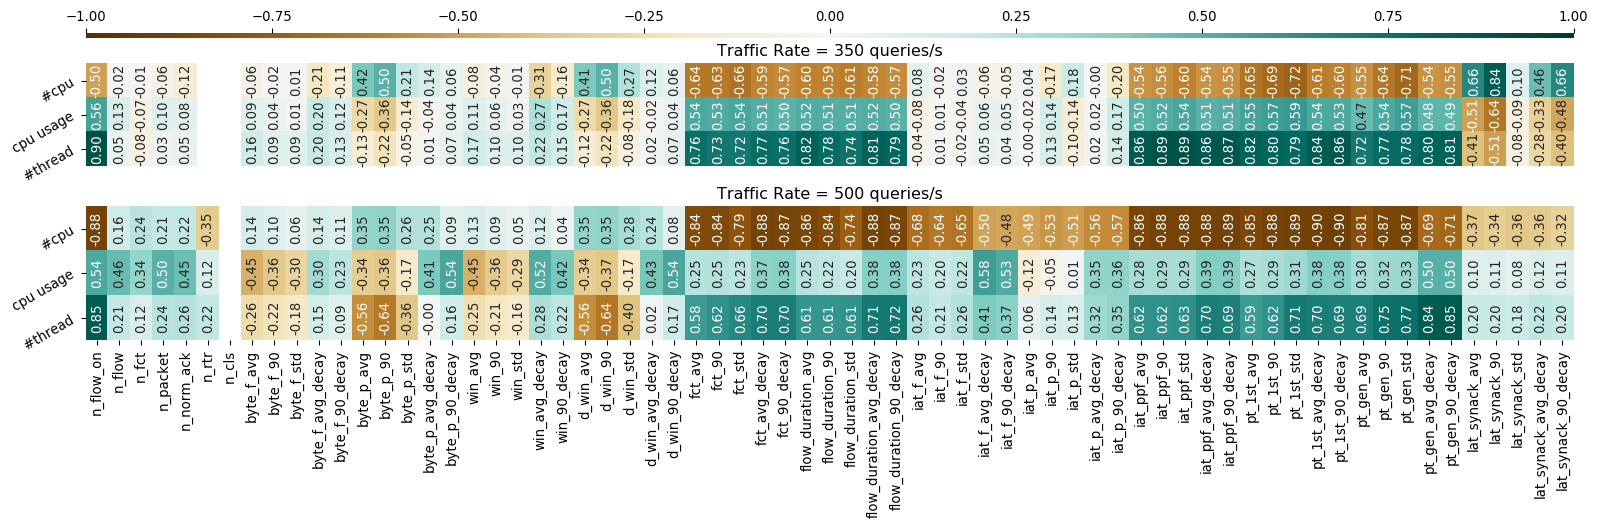

plot for trace PHP File


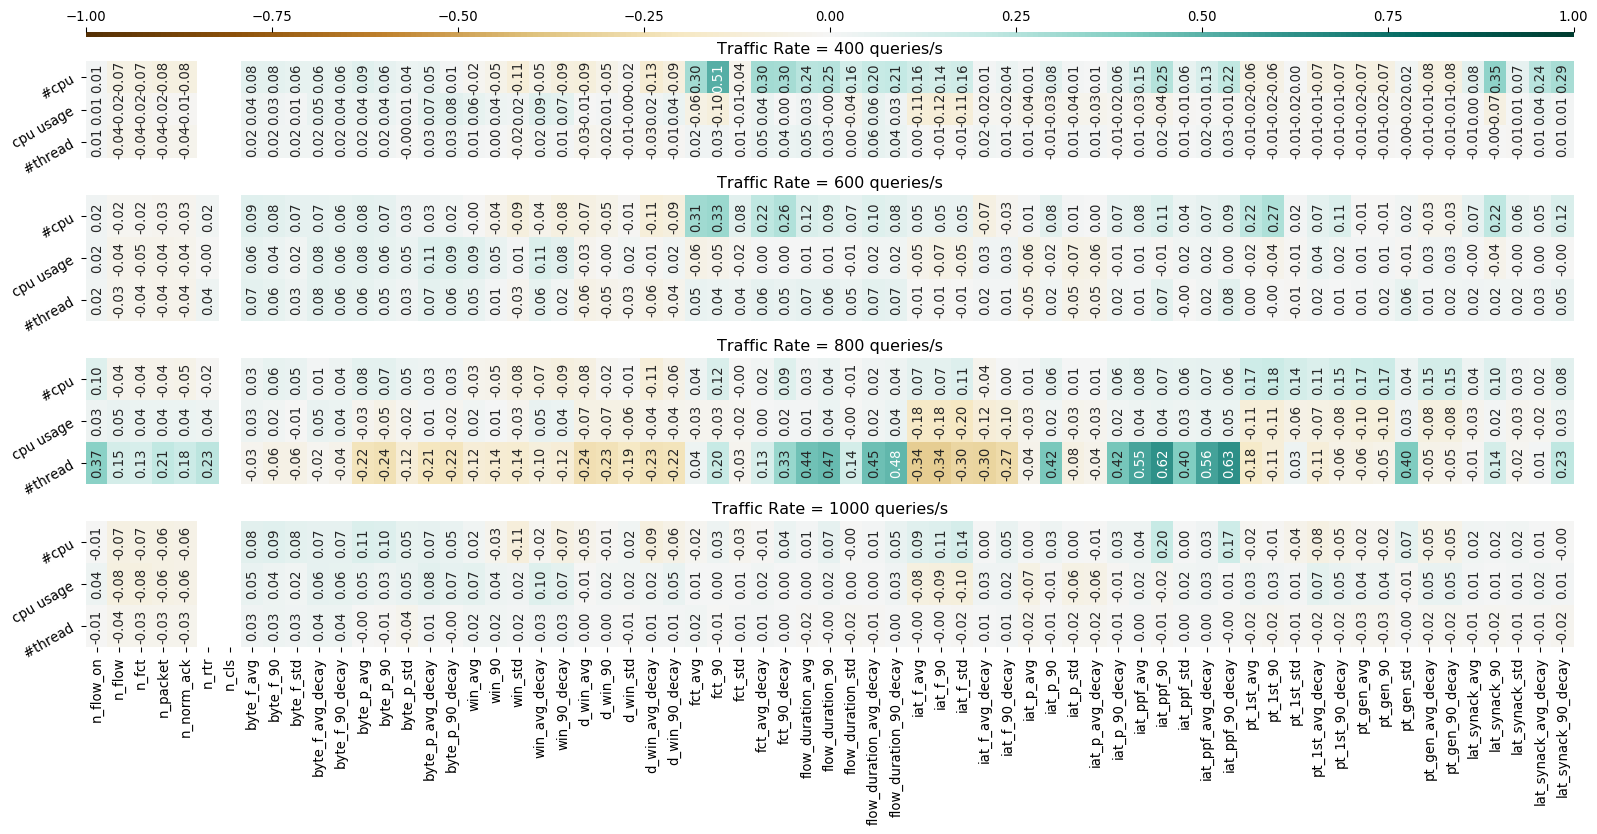

plot for trace Wiki


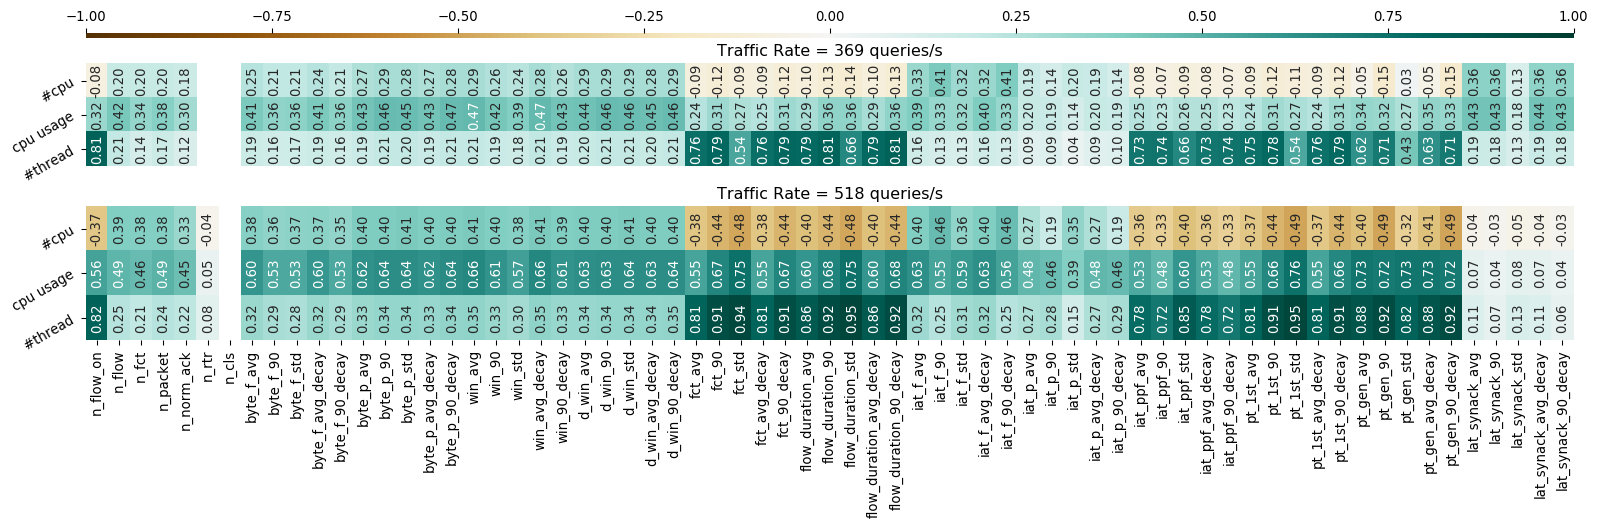

In [91]:
for trace in trace_types:
    plot_heatmap(trace)

### Plot PCA

In [94]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

df_all = df_all.loc[df_all['memory']>0]
pca = PCA()
col2pca = [col for col in col2plot if col not in ['n_rtr', 'n_dpk', 'n_cls', 'n_ooo']]
X = pca.fit_transform(df_all[col2pca].values)
y_trace = df_all['Trace'].values
color_map = {t: COLORS[i] for i,t in enumerate(['Wiki', 'PHP For-Loop', 'PHP File'])}

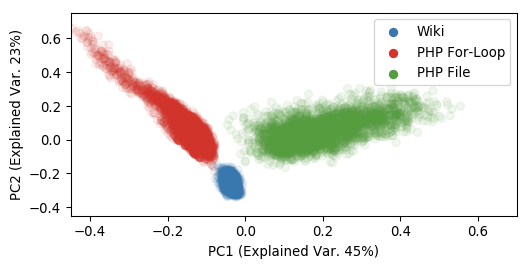

In [96]:
f = plt.figure(figsize=(6,2.8), dpi=96)
xs = X[::5, 0] # sub-sample to speed up
ys = X[::5, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.scatter(xs * scalex,ys * scaley, c=[color_map[t] for t in y_trace[::5]], alpha=0.08)
for k, v in color_map.items():
    plt.scatter([], [], c=v, label=k)
plt.xlim(-0.45, 0.7)
plt.ylim(-0.45, 0.75)
plt.xlabel("PC{} (Explained Var. {:.0%})".format(1, pca.explained_variance_ratio_[0]))
plt.ylabel("PC{} (Explained Var. {:.0%})".format(2, pca.explained_variance_ratio_[1]))
plt.legend()
plt.grid(False)
plt.show()

## Overhead Analysis

### Poisson For-Loop Trace

In [19]:
methods = ['aquarius_ecmp', 'maglev']
rates = [150, 200]
samples = ['rate_{}.csv'.format(i) for i in rates]
config_prefix = ['2lb-72cpu']
trace = 'poisson_for_loop'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
for method in methods:
    print("=== running method {} ===".format(method))
    for sample in samples:
        print(">> sample {}".format(sample))
        for config in config_prefix:
            run_pipeline(
                lb_method=method,
                trace=trace,
                experiment=EXPERIMENT,
                sample=sample,
                from_orig=from_orig,
                config_file_prefix=config,
                clip_n=clip_n,
                n_episode=n_episode,
                episode_base=episode_base
                remote_servers=remote_servers,
                clt_server=clt_server,
            )

### Plot

In [8]:
COLORS_DICT = {
    'aquarius_ecmp': "#508fc3", 
    'maglev': "#d1342b", 
}

MARKER_DICT = {
    'maglev':       ".",
    'aquarius_ecmp':    "x",
}

LINESTYLE_DICT = {
    'maglev':       "--",
    'aquarius_ecmp':    "-",
}

METHOD_MAPPER = {
    'aquarius_ecmp': "Aquarius ECMP", 
    'maglev': "Maglev", 
}

In [17]:
conf = '1x-2lb-72cpu'
page_load_time_res = {}
for rate in rates:
    page_load_time_res[rate] = {}
    for method in methods:
        print(">> loading method:", method)
        _task, _dir = tu.get_task_name_dir(EXPERIMENT, trace, method, sample='rate_{:d}'.format(rate), alias=conf)
        page_load_time_res[rate][method] = get_page_load_time(_dir.replace('results', 'reproduce'))

>> loading method: maglev
>> loading method: aquarius_ecmp
>> loading method: maglev
>> loading method: aquarius_ecmp


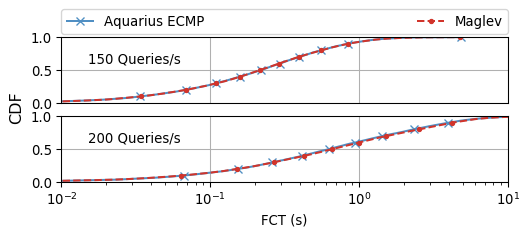

In [20]:
xlims=[[1e-2, 10],[1e-2, 10]]
n_subplots = 2
# xlim=None
fig, axs = plt.subplots(n_subplots, figsize=(6, 2), dpi=96, sharex=False, sharey=True)
fig.suptitle('CDF', position=(0.048, .6), rotation='vertical')
for i, ylabel, xlim in zip(range(n_subplots), rates, xlims):
    for method in methods:
        if method in ['hlb']: continue
        v = page_load_time_res[ylabel][method]['page_load_time']
        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), linestyle=linestyle, color=color)
        axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

    axs[i].set_xlim(xlim)
    axs[i].set_ylim([0.,1.])
    axs[i].grid(True)
    if i == 0:
#         axs[i].axes.xaxis.set_visible(False)
        axs[i].set_xticks([1e-1, 1], ['', ''])
        axs[i].tick_params(axis='x', colors='w', which='both')
    plt.sca(axs[i])
    plt.text(1.5e-2, 0.6, '{} Queries/s'.format(ylabel))
#     axs[i].set_title()
    if i == n_subplots-1: axs[i].set_xlabel('FCT (s)')
    if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
